In [145]:
import pandas as pd
import numpy as np
import rioxarray
import rasterio

import matplotlib.pyplot as plt

import gpflow
import tensorflow as tf

from sklearn.model_selection import train_test_split

In [146]:
uganda_data = pd.read_csv("StandardizedUganda/mock_malaria_cases_uganda_2km_2000.csv")

In [147]:
Z = uganda_data["malaria"].to_numpy().reshape(-1, 1)

In [148]:
x = uganda_data["x"].to_numpy()

In [149]:
y = uganda_data["y"].to_numpy()

In [150]:
lst = uganda_data["lst"].to_numpy()

In [151]:
rain = uganda_data["rainfall"].to_numpy()

In [152]:
X = np.stack((x, y, lst, rain), axis = -1)

In [153]:
rbf = gpflow.kernels.RBF(active_dims = [0, 1])
linear = gpflow.kernels.Linear(active_dims = [2, 3])
kernel = rbf + linear

In [154]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Z, test_size=0.95)

In [155]:
model = gpflow.models.GPR(data = (X_train, Y_train), kernel = kernel)

In [156]:
opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -14.065669479889529
        x: [ 1.479e+01 -3.181e+00 -6.058e+00 -5.481e+00]
      nit: 20
      jac: [ 6.731e-07 -2.767e-05 -8.166e-05  4.662e-05]
     nfev: 30
     njev: 30
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [157]:
malaria_prevalence = rioxarray.open_rasterio("StandardizedUganda/mock_malaria_prevelance_uganda_2km_2000.tif").squeeze()

In [158]:
left, bottom, right, top = malaria_prevalence.rio.bounds()

In [159]:
x = np.linspace(left, right, 285)
y = np.linspace(bottom, top, 285)
x1, x2 = np.meshgrid(x, y)
X_grid = np.stack((x1.ravel(), x2.ravel()), axis = -1)

In [160]:
with rasterio.open("StandardizedUganda/standard_uganda_LSTday_2km_2000.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
lst_data = np.array(values)

In [161]:
with rasterio.open("StandardizedUganda/standard_uganda_Rainfall_CHIRPS_2km_2000.tif") as src:
    # Initialize an empty list to store the sampled values
    values = []
    
    # Sample the raster at the points
    for point in X_grid:
        # Sample the raster at each point
        for val in src.sample([point.tolist()]):
            values.append(val[0])

# Convert the list of values to a numpy array
rain_data = np.array(values)

In [162]:
X_grid = np.concatenate((X_grid, lst_data[:, np.newaxis], rain_data[:, np.newaxis]), axis = -1)

In [163]:
tf.experimental.numpy.experimental_enable_numpy_behavior()

In [164]:
# Make predictions on the grid
Z_fmean_grid, Z_fvar_grid = model.predict_f(X_grid)

# Reshape the grid predictions to match the grid shape
Z_fmean_grid = Z_fmean_grid.reshape(x1.shape)
Z_fvar_grid = Z_fvar_grid.reshape(x1.shape)

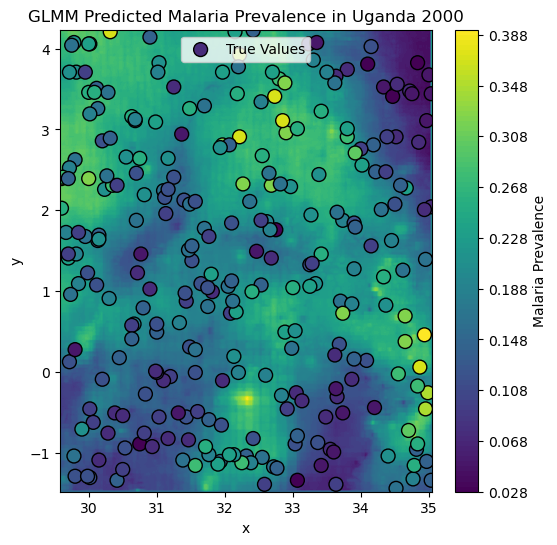

In [168]:
plt.figure(figsize=(6, 6))
plt.contourf(x, y, Z_fmean_grid, levels=100, cmap='viridis')
plt.colorbar(label='Malaria Prevalence')

# Overlay the true values of the test data
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolor='k', cmap='viridis', marker='o', s=100, label='True Values')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('GLMM Predicted Malaria Prevalence in Uganda 2000')
plt.savefig("StandardizedUganda/mock_malaria_cases_uganda_randomfield_2km_2000.png") 
plt.show()